In [386]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.font_manager
import dash

In [387]:
df = pd.read_excel("data/20191116_Misstarget_Abuse_Pattern.xlsx")

In [388]:
df.shape

(13469, 32)

In [389]:
selected_cols = [
    "MonthReport",
    "REF_UID",
    "PROJECT_NAME",
    "PM_NAME",
    "PD_NAME",
    "Forecast_Cash_Flow_Display",
    "Actual_Cash_Flow_Display",
    "Tolerances_Name"
]

In [390]:
df.columns

Index(['DATA_TYPE', 'MonthReport', 'REF_UID', 'PROJECT_NAME', 'PM_ID',
       'PM_NAME', 'PD_ID', 'PD_NAME', 'BUDGET', 'Quarter',
       'Forecast_Cash_Flow', 'Actual_Cash_Flow', 'Forecast_Cash_Flow_Display',
       'Actual_Cash_Flow_Display', 'Variance_Display', 'Variance',
       'Percentage', 'Percentage_Display', 'Color', 'Tolerance_Level',
       'PC_Date', 'ClOSE_DATE', 'Tolerances_Name', 'Forecast_Cash_Flow_Total',
       'Forecast_Cash_Flow_Total_Display', 'Actual_Cash_Flow_Total',
       'Actual_Cash_Flow_Total_Display', 'Variance_Total',
       'Variance_Total_Display', 'Percentage_Average',
       'Percentage_Average_Display', 'TIMESTAMP'],
      dtype='object')

In [391]:
df = df[selected_cols]

In [392]:
df.head()

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
0,2017-07,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Nicole Collin,0.0,5.46,Meet Target
1,2017-08,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,44.19,Meet Target
2,2017-09,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,17.02,Meet Target
3,2017-10,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,3.59,Meet Target
4,2017-11,83,Project Feasibility Assessments - Prior to 2015,Michael Scott,Program Admin,0.0,4.13,Meet Target


##### Remove Project with `Tolerances_Name` == `Not Applicable`

In [393]:
df = df[df['Tolerances_Name']!='Not Applicable']

##### Remove Project with PD_NAME=Program Admin

In [394]:
df = df[df['PD_NAME']!='Program Admin']

##### Remove Project with Forecast=0 and Actual=0

In [395]:
df = df[~((df['Forecast_Cash_Flow_Display']==0) & (df['Actual_Cash_Flow_Display']==0))]

##### Remove PM in List

In [396]:
PM_remove = [
    'Carol Loh',
    'Loi Tran',
    'Axel Keert',
    'Program Admin',
    'Michael Scott',
    'Program Close',
    'Bradley Williamson',
    'Richard Feltscheer',
    'Tish Booth',
    'Stephen Lindsay',
    'David Baker',
    'Nethmi Dassanayake'
]
df = df[~df['PM_NAME'].isin(PM_remove)]

In [397]:
df[df['Forecast_Cash_Flow_Display']==0].shape

(730, 8)

##### Remove SSAF Project with < 50K

In [398]:
# name = 'Angus McGarvie'
# name = 'Jonathon Egan '
# df[df['PM_NAME']==name][df['Forecast_Cash_Flow_Display']==0][df['Actual_Cash_Flow_Display']>50].shape[0] /df[df['PM_NAME']==name].shape[0]

In [399]:
# df[df['PM_NAME']==name][df['Forecast_Cash_Flow_Display']==0].shape

In [400]:
df = df[~(df['PROJECT_NAME'].str.contains('SSAF') & (df['Actual_Cash_Flow_Display']<50) & (df['Forecast_Cash_Flow_Display']==0))]

##### Remove Project ID = 1162

In [401]:
df = df[df['REF_UID']!=1162]

In [402]:
# year_list = ['2016', '2017', '2018', '2019']
# for year in year_list:
#     print(f"{year}: {df[(df['MonthReport'].str.contains(year))].shape[0]}")

In [403]:
# # Exclude 2016 and 2017
# df = \
# df[(df['MonthReport'].str.contains('2018')) \
#    | (df['MonthReport'].str.contains('2019')) 
#   ]

In [404]:
print(f"Total Project in: {df.shape[0]}")

Total Project in: 5959


In [405]:
df_analytics = df.copy()

In [406]:
# df_analytics['Forecast_Variation'] = df_analytics['Forecast_Cash_Flow_Display'] - df_analytics['Actual_Cash_Flow_Display']
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation'] / (df_analytics['Actual_Cash_Flow_Display'] + 0.001)
# df_analytics['Forecast_Variation_Perc'] = df_analytics['Forecast_Variation_Perc'].astype('float')
df_analytics['Forecast_Cash_Flow_Display'] = df_analytics['Forecast_Cash_Flow_Display'].astype('float')
df_analytics['Actual_Cash_Flow_Display'] =  df_analytics['Actual_Cash_Flow_Display'].astype('float')

In [407]:
df_analytics.head(10)

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
19,2016-08,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,921.74,173.18,Critical
20,2016-09,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,460.99,432.22,Critical
21,2016-10,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,981.38,1023.41,Meet Target
22,2016-11,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,916.94,891.59,Near Target
23,2016-12,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,4421.56,0.00,Critical
24,2017-01,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,22.00,1.90,Critical
25,2017-02,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,666.74,593.27,Critical
26,2017-03,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,812.64,157.11,Critical
27,2017-04,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,1106.76,1347.66,Meet Target
28,2017-05,271,Matheson Library Refurbishment,Mark Soderlund,Kevin Weatherall,1272.57,1100.23,Critical


In [408]:
# PM_name = 'Angus McGarvie'
# PM_name = 'Dean Ristevski'
PM_name = 'Jeremy Chong'
df_person = df_analytics[df_analytics['PM_NAME']==PM_name]
# df_person[df_person['Forecast_Cash_Flow_Display']==0]
df_person.head(3)

,MonthReport,REF_UID,PROJECT_NAME,PM_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
110,2017-03,353,Clayton JMR Nature Walk and Monash Tan,Jeremy Chong,Nicole Collin,9.00,9.39,Meet Target
111,2017-04,353,Clayton JMR Nature Walk and Monash Tan,Jeremy Chong,Nicole Collin,11.05,0.00,Critical
113,2017-06,353,Clayton JMR Nature Walk and Monash Tan,Jeremy Chong,Nicole Collin,0.00,1.72,Meet Target


In [409]:
underspend = df_person[(df_person['Forecast_Cash_Flow_Display'] - df_person['Actual_Cash_Flow_Display']) * 2 \
                    /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05].shape[0]
print(f"underspend:{underspend}")
overderspend = df_person[(df_person['Actual_Cash_Flow_Display'] - df_person['Forecast_Cash_Flow_Display']) * 2 \
                    /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05].shape[0]
print(f"overderspend:{overderspend}")

underspend:77
overderspend:76


In [410]:
# df_person[(df_person['Forecast_Cash_Flow_Display'] - df_person['Actual_Cash_Flow_Display']) * 2 \
#                     /(df_person['Actual_Cash_Flow_Display'] + df_person['Forecast_Cash_Flow_Display'])>0.05]

In [411]:
df_0 = df[df['Forecast_Cash_Flow_Display']==0]
df_0.groupby(['PM_NAME']).count().sort_values('MonthReport',ascending=False)

,MonthReport,REF_UID,PROJECT_NAME,PD_NAME,Forecast_Cash_Flow_Display,Actual_Cash_Flow_Display,Tolerances_Name
PM_NAME,,,,,,,
Angus McGarvie,120,120,120,120,120,120,120
Jeremy Chong,43,43,43,43,43,43,43
Dean Ristevski,37,37,37,37,37,37,37
Aarron Cowen,33,33,33,33,33,33,33
Ron Too,25,25,25,25,25,25,25
Jonathon Egan,24,24,24,24,24,24,24
Nick Ditterich,21,21,21,21,21,21,21
Arash Emami,20,20,20,20,20,20,20
Mark Bray,19,19,19,19,19,19,19


In [412]:
PM_list = list(set(df_analytics['PM_NAME']))

In [518]:
pm_perf = dict()

for name in PM_list:
#     if name != 'Angus McGarvie':
#     if name != 'Aarron Cowen':
#     if name != 'Matthew Bartlett':
#         continue

    df_tmp = df_analytics[df_analytics['PM_NAME']==name]
    mse = mean_squared_error(df_tmp['Actual_Cash_Flow_Display'], df_tmp['Forecast_Cash_Flow_Display']) / sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Project Delivered
    project_num = df_tmp.shape[0]
    
    # Metric: Total Project Value Delivered
    project_value = df_tmp['Actual_Cash_Flow_Display'].sum()
    project_value_inv = 1.0 / np.sqrt(project_value)
    
    # Metric: Number of Time that Put Forecast as Zero
    zero_fcst = df_tmp[df_tmp['Forecast_Cash_Flow_Display']==0].shape[0]
    
    # Metric KS Distribution
#     ks_distrb = ks_2samp(df_tmp['Forecast_Cash_Flow_Display'], df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Number of Time that Missing Target
    underspend = df_tmp[(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] + df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
                        
    overderspend = df_tmp[(df_tmp['Actual_Cash_Flow_Display'] - df_tmp['Forecast_Cash_Flow_Display']) * 2 \
                        /(df_tmp['Actual_Cash_Flow_Display'] + df_tmp['Forecast_Cash_Flow_Display'])>0.05].shape[0]
    
    underspend_project_num = underspend
    overspend_project_num = overderspend
   
    # Metric: Overspend/Underspend $
    df_tmp['spend_diff'] = df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']
    underspend_value = abs(sum(df_tmp[df_tmp['spend_diff']>0]['spend_diff']))                       
    overderspend_value = abs(sum(df_tmp[df_tmp['spend_diff']<0]['spend_diff']))  


    miss_target_project_num = underspend + overderspend

    # Metric: Percentage of Miss-target Project
    miss_target_project_ratio = miss_target_project_num / project_num

    
    # Metric: MAPE
    df_tmp.loc[:,'miss_taget_value_monthly_mape'] = abs(df_tmp['Forecast_Cash_Flow_Display'] - df_tmp['Actual_Cash_Flow_Display']) * 2 /\
                                           (df_tmp['Forecast_Cash_Flow_Display'] + df_tmp['Actual_Cash_Flow_Display'])
    
    miss_taget_value_monthly_mape = df_tmp['miss_taget_value_monthly_mape'].mean()
    
    # Metric: Total Missing Target $ Value (Can Cancel Off)
    miss_target_value = sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])
    
    # Metric: Total Missing Target $ Value Percentage (Can Cancel Off)    
    miss_target_value_perc_error = abs(sum(df_tmp['Forecast_Cash_Flow_Display']) - sum(df_tmp['Actual_Cash_Flow_Display'])) * 2 / \
                                   (sum(df_tmp['Forecast_Cash_Flow_Display']) + sum(df_tmp['Actual_Cash_Flow_Display']))

    # Metric: Total Logged Missing Target Absolute $ Value (Can't Cancel Off)    
    miss_target_value_log_error = np.log(sum(abs((df_tmp['Forecast_Cash_Flow_Display']) - (df_tmp['Actual_Cash_Flow_Display']))))
    
    pm_perf[name] = [
        project_num,
        project_value,
        project_value_inv,
        zero_fcst,
#         ks_distrb,
        miss_taget_value_monthly_mape,
        miss_target_project_num,
        underspend_project_num,
        overspend_project_num,
        underspend_value,
        overderspend_value,
        miss_target_project_ratio,
        miss_target_value,
        miss_target_value_perc_error,
        miss_target_value_log_error
    ]

In [519]:
df_pm_perf = pd.DataFrame.from_dict(pm_perf, orient='index',
                                 columns=['project_num',
                                          'project_value',
                                          'project_value_inv',
                                          'zero_fcst',
#                                           'ks_distrb',
                                          'miss_taget_value_monthly_mape',
                                          'miss_target_project_num',
                                          'underspend_project_num',
                                          'overspend_project_num',
                                          'underspend_value',
                                          'overderspend_value',
                                          'miss_target_project_ratio',
                                          'miss_target_value',
                                          'miss_target_value_perc_error',
                                          'miss_target_value_log_error'
                                         ])

In [520]:
# Only track PMs who have delivered >10 project and total project value > $50K
df_pm_perf = df_pm_perf[(df_pm_perf['project_num']>=10) | (df_pm_perf['project_value']>=50)]

In [521]:
df_pm_perf.sort_values('miss_taget_value_monthly_mape').tail(3)

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Jodie Katada,35,891.81,0.033486,15,1.581520,33,16,17,347.98,644.99,0.942857,-297.01,0.399580,6.900700
Anthony Douglas,15,428.61,0.048302,1,1.780311,15,12,3,645.14,262.39,1.000000,382.75,0.617354,6.810727
Jarrod Filosa,16,40.94,0.156288,0,1.787894,16,16,0,362.09,0.00,1.000000,362.09,1.631146,5.891893


#### Good PM

In [522]:
df_pm_perf[(df_pm_perf.index=='Dean Ristevski') \
           | (df_pm_perf.index=='Jeremy Chong') \
           | (df_pm_perf.index=='Jonathon Egan ')\
           | (df_pm_perf.index=='Arash Emami')\
           | (df_pm_perf.index=='James Creech')\
           | (df_pm_perf.index=='Ryan Spittel')
          ]

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Dean Ristevski,160,18262.54,0.007400,37,1.116396,132,47,85,2896.56,6226.42,0.825000,-3329.86,0.200623,9.118552
Jeremy Chong,186,10364.64,0.009823,43,1.091752,153,77,76,2259.08,957.91,0.822581,1301.17,0.118125,8.076201
Arash Emami,167,28142.62,0.005961,20,0.787499,118,49,69,6570.65,6407.66,0.706587,162.99,0.005775,9.471035
Ryan Spittel,167,44962.63,0.004716,10,0.954412,126,95,31,8997.13,2584.05,0.754491,6413.08,0.133137,9.357137
James Creech,77,6416.33,0.012484,5,0.949461,57,37,20,1395.52,566.23,0.740260,829.29,0.121401,7.581592
Jonathon Egan,543,15112.94,0.008134,24,1.246433,463,362,101,5574.96,3123.37,0.852670,2451.59,0.150048,9.070886


#### Bad PM

In [523]:
df_pm_perf[(df_pm_perf.index=='Angus McGarvie') \
           | (df_pm_perf.index=='Aarron Cowen') \
           | (df_pm_perf.index=='Eric Sun') \
           | (df_pm_perf.index=='Bijins Joy')           
          ]

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,underspend_value,overderspend_value,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Angus McGarvie,294,28349.77,0.005939,120,1.434190,270,103,167,5317.00,16485.34,0.918367,-11168.34,0.490580,9.989773
Bijins Joy,46,1020.19,0.031308,8,0.757145,32,9,23,38.02,255.90,0.695652,-217.88,0.239100,5.683308
Aarron Cowen,359,15062.46,0.008148,33,1.331137,337,241,96,12577.06,3815.81,0.938719,8761.25,0.450610,9.704602
Eric Sun,125,195897.41,0.002259,9,0.736999,93,56,37,62532.37,14349.76,0.744000,48182.61,0.219023,11.250029


In [419]:
df_pm_perf.sort_values('miss_target_value_perc_error')

,project_num,project_value,project_value_inv,zero_fcst,miss_taget_value_monthly_mape,miss_target_project_num,underspend_project_num,overspend_project_num,miss_target_project_ratio,miss_target_value,miss_target_value_perc_error,miss_target_value_log_error
Arash Emami,167,28142.62,0.005961,20,0.787499,118,49,69,0.706587,162.99,0.005775,9.471035
Mark Barrett,4,351.26,0.053356,0,0.615225,4,2,2,1.000000,2.76,0.007827,5.093259
Jack Izowski,155,16782.69,0.007719,18,1.122624,139,79,60,0.896774,408.03,0.024021,9.446920
Ryan Martin,43,2450.63,0.020200,10,0.935929,31,16,15,0.720930,86.42,0.034653,6.469901
Adel Mousa,88,16605.36,0.007760,10,1.112681,80,46,34,0.909091,609.31,0.036032,9.272653
Hiruni Eriyagama,104,6758.48,0.012164,13,1.074298,90,48,42,0.865385,-250.39,0.037748,8.292576
Nick Ditterich,114,17648.42,0.007527,21,1.108406,102,57,45,0.894737,-885.62,0.051473,9.095015
Alexis Kouts,219,118123.12,0.002910,19,1.008290,182,136,46,0.831050,9509.13,0.077387,9.535362
Yolande O'Mara,59,3024.61,0.018183,10,0.848497,49,24,25,0.830508,-291.12,0.101117,7.202706
Robert Dickson,14,1402.31,0.026704,3,1.375616,14,7,7,1.000000,166.36,0.111990,6.452869


In [420]:
col_list = [
    'zero_fcst',
    'project_value_inv',
    'miss_taget_value_monthly_mape',  
    'miss_target_project_ratio',
#     'miss_target_value',
    'miss_target_value_perc_error',
#     'miss_target_value_log_error'
]

df_pm_perf_select = df_pm_perf[col_list].dropna()

In [421]:
df_pm_perf_select.head(3)

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error
Robert Dickson,3,0.026704,1.375616,1.000000,0.11199
Angus McGarvie,120,0.005939,1.434190,0.918367,0.49058
Paul Borci,0,0.018755,1.130300,1.000000,0.58173


In [422]:
for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [423]:
data = df_pm_perf_select[col_list].as_matrix()

In [424]:
top_n_outlier = 20
num_PM = len(PM_list)
outliers_fraction = top_n_outlier * 1.0 / num_PM

In [425]:
select_metrics= [
    'miss_taget_value_monthly_mape',
    'project_value_inv',
    'project_value_inv',
    'miss_target_project_ratio',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
    'miss_target_value_perc_error',
#     'miss_target_value',
#     'miss_target_value_log_error'
]

In [426]:
df_pm_perf_select[select_metrics]

,miss_taget_value_monthly_mape,project_value_inv,project_value_inv,miss_target_project_ratio,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error,miss_target_value_perc_error
Robert Dickson,0.769406,0.170865,0.170865,1.000000,0.068657,0.068657,0.068657,0.068657,0.068657,0.068657,0.068657,0.068657
Angus McGarvie,0.802167,0.038001,0.038001,0.918367,0.300758,0.300758,0.300758,0.300758,0.300758,0.300758,0.300758,0.300758
Paul Borci,0.632196,0.120000,0.120000,1.000000,0.356639,0.356639,0.356639,0.356639,0.356639,0.356639,0.356639,0.356639
Dean Ristevski,0.624420,0.047347,0.047347,0.825000,0.122995,0.122995,0.122995,0.122995,0.122995,0.122995,0.122995,0.122995
Dody Kurnianto,0.747595,0.214222,0.214222,0.911765,0.441361,0.441361,0.441361,0.441361,0.441361,0.441361,0.441361,0.441361
Vivienne Elder-Smith,0.647680,0.094498,0.094498,0.870968,0.368226,0.368226,0.368226,0.368226,0.368226,0.368226,0.368226,0.368226
Justin Collin,0.615179,0.037099,0.037099,0.947917,0.168644,0.168644,0.168644,0.168644,0.168644,0.168644,0.168644,0.168644
Julian Smith,0.721086,0.063322,0.063322,0.952381,0.204645,0.204645,0.204645,0.204645,0.204645,0.204645,0.204645,0.204645
Gavin Zhang,0.543374,0.272239,0.272239,0.785714,0.287929,0.287929,0.287929,0.287929,0.287929,0.287929,0.287929,0.287929
Bijins Joy,0.423484,0.200324,0.200324,0.695652,0.146584,0.146584,0.146584,0.146584,0.146584,0.146584,0.146584,0.146584


In [427]:
df_pm_perf_select['pm_performance_score[abs]'] = 1 - df_pm_perf_select.apply(lambda x: np.linalg.norm(x[select_metrics]), axis=1)/np.sqrt(len(select_metrics))

In [428]:
print(f"Median Score: {df_pm_perf_select['pm_performance_score[abs]'].median():.02f}")

Median Score: 0.65


In [429]:
df_pm_perf_select.sort_values('pm_performance_score[abs]', ascending=False).tail(20)

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Matthew Behn,0.066667,0.050142,0.757602,0.888889,0.243855,0.607908
Aarron Cowen,0.275000,0.052135,0.744528,0.938719,0.276254,0.586531
David Tabatabaian,0.008333,0.897193,0.336859,0.600000,0.101901,0.575103
Angus McGarvie,1.000000,0.038001,0.802167,0.918367,0.300758,0.570524
Jodie Katada,0.125000,0.214258,0.884571,0.942857,0.244969,0.567629
Vivienne Elder-Smith,0.141667,0.094498,0.647680,0.870968,0.368226,0.564047
David Chauhan,0.108333,0.047708,0.796778,0.953995,0.308875,0.560991
Paul Borci,0.000000,0.120000,0.632196,1.000000,0.356639,0.548521
Anna Devlin,0.050000,0.192490,0.721958,1.000000,0.330707,0.546287
Daniel Bartel,0.000000,0.205828,0.530347,0.812500,0.432465,0.541528


In [430]:
df_pm_perf_select[(df_pm_perf_select.index=='Dean Ristevski') \
           | (df_pm_perf_select.index=='Jeremy Chong') \
           | (df_pm_perf_select.index=='Jonathon Egan ')\
           | (df_pm_perf_select.index=='Arash Emami')\
           | (df_pm_perf_select.index=='James Creech')\
           | (df_pm_perf_select.index=='Ryan Spittel')
          ]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Dean Ristevski,0.308333,0.047347,0.624420,0.825000,0.122995,0.684296
Jeremy Chong,0.358333,0.062849,0.610636,0.822581,0.072418,0.697322
Arash Emami,0.166667,0.038141,0.440462,0.706587,0.003540,0.759119
Ryan Spittel,0.083333,0.030175,0.533819,0.754491,0.081622,0.724722
James Creech,0.041667,0.079879,0.531050,0.740260,0.074427,0.728112
Jonathon Egan,0.200000,0.052047,0.697152,0.852670,0.091989,0.672614


In [431]:
df_pm_perf_select[(df_pm_perf_select.index=='Angus McGarvie') \
           | (df_pm_perf_select.index=='Aarron Cowen') \
           | (df_pm_perf_select.index=='Eric Sun') \
           | (df_pm_perf_select.index=='Bijins Joy')           
          ]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs]
Angus McGarvie,1.000000,0.038001,0.802167,0.918367,0.300758,0.570524
Bijins Joy,0.066667,0.200324,0.423484,0.695652,0.146584,0.723802
Aarron Cowen,0.275000,0.052135,0.744528,0.938719,0.276254,0.586531
Eric Sun,0.075000,0.014456,0.412216,0.744000,0.134276,0.731034


In [432]:
classifiers = {
#         'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
#         'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=42),
#         'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=42),
#         'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
#         'Isolation Forest': IForest(contamination=outliers_fraction,random_state=42),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
#         'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [433]:
col_list = ['pm_performance_score[abs]', 'zero_fcst']

for col in col_list:
    df_pm_perf_select[col] = df_pm_perf_select[col] / df_pm_perf_select[col].max()

In [434]:
top_n_outlier = 5

X_train = df_pm_perf_select[col_list].as_matrix()

0.8538548187482136

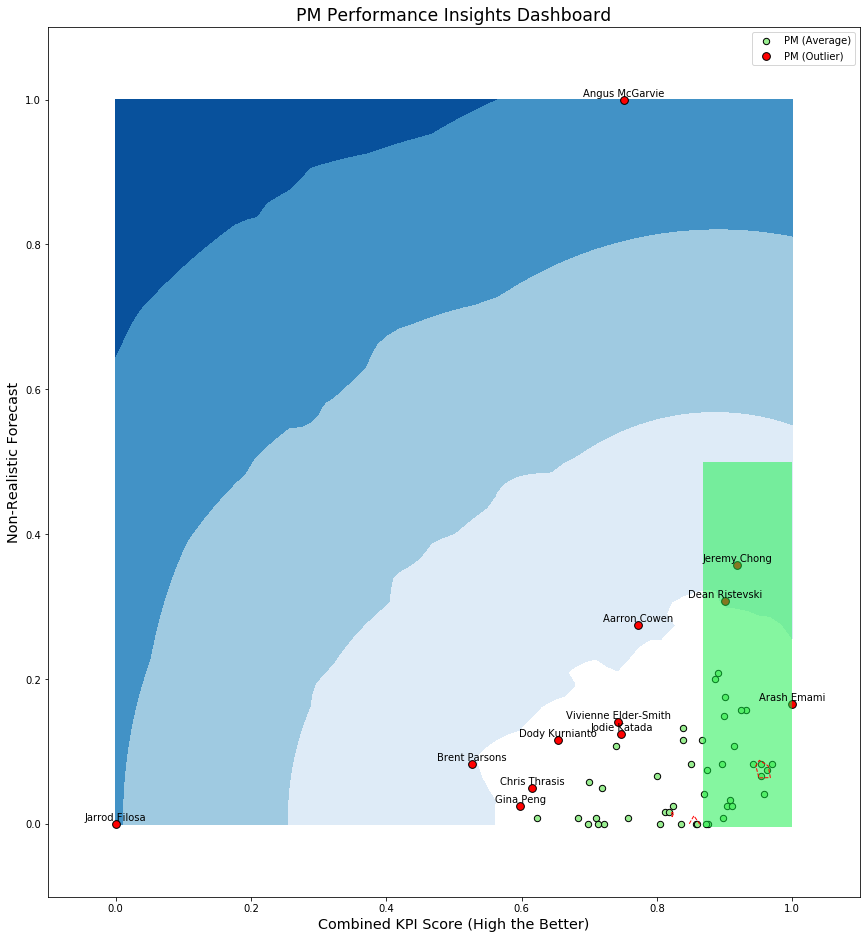

In [586]:
#set the figure size

fig = plt.figure(figsize=(32, 16))

xx , yy = np.meshgrid(np.linspace(0, 1, num_PM), np.linspace(0, 1, num_PM))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)
    threshold = np.percentile(y_pred_proba[:,0], 20)
    y_pred = np.where(y_pred_proba[:,0]>threshold, 0, 1)
    
    df_pm_perf_select['outlier'] = y_pred
    
    perf_median = np.median(df_pm_perf_select[df_pm_perf_select['outlier']!=1]['pm_performance_score[abs]'].values)
    
    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred, top_n_outlier)

#     # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold+0.02, 5),cmap=plt.cm.Blues_r)

#     # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold+0.12],linewidths=1, colors='red')

#     # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
#     subplot.contourf(xx, yy, Z, levels=[threshold+0.02, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
#     b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 

    df_pm_perf_select_ok = df_pm_perf_select[df_pm_perf_select['outlier']==0]
    df_pm_perf_select_under = df_pm_perf_select[df_pm_perf_select['outlier']==1]

    inlier = subplot.scatter(df_pm_perf_select_ok[col_list[0]], df_pm_perf_select_ok[col_list[1]], c='#99EE90',s=40, edgecolor='k') 
    outlier = subplot.scatter(df_pm_perf_select_under[col_list[0]], df_pm_perf_select_under[col_list[1]], c='red',s=60, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
#         [a.collections[0], inlier, outlier],
#         ['Performance Boundary', 'PM (Average)', 'PM (Outlier)'],
        [inlier, outlier],
        ['PM (Average)', 'PM (Outlier)'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='higher right')

    subplot.set_title("PM Performance Insights Dashboard", fontsize='xx-large')
    x_axis_max = df_pm_perf_select[col_list[0]].max()*1.1
    x_axis_min = min(df_pm_perf_select[col_list[0]].min()*1.1, -0.1)
    y_axis_max = df_pm_perf_select[col_list[1]].max()*1.1
    y_axis_min = min(df_pm_perf_select[col_list[1]].min()*1.1, -0.1)
    plt.axvspan(perf_median, 1, ymin = 0.08, ymax = 0.5, facecolor='#0DEF42', alpha=0.5)
    
    subplot.set_xlim((x_axis_min, x_axis_max))
    subplot.set_ylim((y_axis_min, y_axis_max))
    subplot.set_xlabel("Combined KPI Score (High the Better)", fontsize='x-large')
    subplot.set_ylabel("Non-Realistic Forecast", fontsize='x-large')
    for index, row in df_pm_perf_select.iterrows():

        label = index
        x = row[col_list[0]]
        y = row[col_list[1]]
        
        if row['outlier']==0:
            continue
            
#         if label != 'Angus McGarvie':
#             continue
            
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,3), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.savefig('./output/pm_performance_dashboard.pdf')
    plt.show()

In [436]:
df_pm_perf_select[df_pm_perf_select['outlier']==1]

,zero_fcst,project_value_inv,miss_taget_value_monthly_mape,miss_target_project_ratio,miss_target_value_perc_error,pm_performance_score[abs],outlier
Angus McGarvie,1.000000,0.038001,0.802167,0.918367,0.300758,0.751560,1
Dean Ristevski,0.308333,0.047347,0.624420,0.825000,0.122995,0.901433,1
Dody Kurnianto,0.116667,0.214222,0.747595,0.911765,0.441361,0.654238,1
Vivienne Elder-Smith,0.141667,0.094498,0.647680,0.870968,0.368226,0.743029,1
Jeremy Chong,0.358333,0.062849,0.610636,0.822581,0.072418,0.918593,1
Arash Emami,0.166667,0.038141,0.440462,0.706587,0.003540,1.000000,1
Jodie Katada,0.125000,0.214258,0.884571,0.942857,0.244969,0.747746,1
Brent Parsons,0.083333,0.142111,0.804737,0.943038,0.586250,0.526302,1
Gina Peng,0.025000,0.207915,0.854568,0.941176,0.484166,0.598011,1
Aarron Cowen,0.275000,0.052135,0.744528,0.938719,0.276254,0.772647,1


In [437]:
df_pm_perf_select[['zero_fcst', 'pm_performance_score[abs]', 'outlier']].reset_index().rename(columns={'index':'pm'}).to_csv('./data/pm_perf.csv', index=False)

In [438]:
pd.read_csv('data/pm_perf.csv').head(3)

,pm,zero_fcst,pm_performance_score[abs],outlier
0,Robert Dickson,0.025,0.823237,0
1,Angus McGarvie,1.000,0.751560,1
2,Paul Borci,0.000,0.722575,0


In [439]:
# df_angus['Forecast_Cash_Flow_Display'].plot(figsize=(24,16))
# df_angus['Actual_Cash_Flow_Display'].plot(figsize=(24,16))

In [440]:
# agg_cond = [
#     'PM_NAME',
# ]
# target = ['Forecast_Variation_Perc']
# selected_cols = agg_cond + target
# agg_ops = [
#     'mean'
# ]
# agg_target = target[0] + '_' + agg_ops[0]
# df_agg = df_analytics[selected_cols].groupby(agg_cond).agg(agg_ops)

# df_agg.columns = ['_'.join(col).strip(' ') for col in df_agg.columns.values]
# df_agg = df_agg.reset_index()

# df_agg.sort_values(agg_target, ascending=False)

In [441]:
import plotly.offline as pyo
import plotly.graph_objs as go

In [587]:
np.random.seed(42)
random_x = np.random.randint(1,101,100)
random_y = np.random.randint(1,101,100)

df = pd.read_csv('data/pm_perf.csv')

data = [go.Scatter(x=[perf_median, perf_median, 1, 1], y=[0, 0.5, 0.5, 0],
                    fill='toself', fillcolor='rgba(135, 206, 250, 0.2)',
                    name="High Performance Area",
                    hoverinfo='text+x+y')]

data = \
data + ([go.Scatter(x=df[df['outlier']==0]['pm_performance_score[abs]'],
                   y=df[df['outlier']==0]['zero_fcst'],
                   text = df[df['outlier']==0]['pm'],
                   mode='markers',
                   name = "PM (Average)",
                   marker=dict(
                     size=8,
                     color='rgb(51,204,153)',
                     symbol='circle',
                     line={'width':2}
                   ))])

data = \
data + ([go.Scatter(x=df[df['outlier']==1]['pm_performance_score[abs]'],
                   y=df[df['outlier']==1]['zero_fcst'],
                   text = df[df['outlier']==1]['pm'],
                   mode='markers',
                   name = "PM (Outlier)",
                   marker=dict(
                     size=8,
                     color='red',
                     symbol='circle',
                     line={'width':2}
                   ))])

layout = go.Layout(title='PM Performance Insights Dashboard',
                   xaxis=dict(title='Combined KPI Score (High the Better)'),
                   yaxis=dict(title='Non-Realistic Forecast'),
                   hovermode='closest')

fig = go.Figure(data=data,layout=layout)

pyo.plot(fig, filename='pm_perf_dashboard_interactive.html')

'pm_perf_dashboard_interactive.html'

In [578]:
df_pm_perf_vis = df_pm_perf[['underspend_value', 'overderspend_value', 'miss_target_project_ratio']].merge(df_pm_perf_select['outlier'], how='inner', left_index=True, right_index =True)

In [579]:
df_pm_perf_vis['underspend_value'] = df_pm_perf_vis['underspend_value'].astype('int')
df_pm_perf_vis['overderspend_value'] = df_pm_perf_vis['overderspend_value'].astype('int')
df_pm_perf_vis['miss_target_project_ratio'] = df_pm_perf_vis['miss_target_project_ratio']*100
df_pm_perf_vis['miss_target_project_ratio'] = df_pm_perf_vis['miss_target_project_ratio'].astype('int')

In [580]:
df_pm_perf_vis = df_pm_perf_vis.reset_index().rename(columns={'index':'pm'})

In [581]:
# import plotly.express as px
# iris = px.data.iris()
# fig = px.scatter_3d(df_pm_perf_vis, 
#                     x='underspend_value', 
#                     y='overderspend_value', 
#                     z='miss_target_project_ratio',
#                     color='outlier'
#                    )
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# pyo.plot(fig, filename='pm_spending_dashboard_interactive.html')

'pm_spending_dashboard_interactive.html'

In [585]:
data=[go.Scatter3d(
    x=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['underspend_value'],
    y=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['overderspend_value'],
    z=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['miss_target_project_ratio'],
    name = "PM (Average)",
    mode='markers',
    text=df_pm_perf_vis[df_pm_perf_vis['outlier']==0]['pm'],
    marker=dict(
        size=5,
#         color=df_pm_perf_vis['outlier'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)]

data = \
data + ([go.Scatter3d(
    x=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['underspend_value'],
    y=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['overderspend_value'],
    z=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['miss_target_project_ratio'],
    mode='markers',
    name = "PM (Outlier)",
    text=df_pm_perf_vis[df_pm_perf_vis['outlier']==1]['pm'],
    marker=dict(
        size=8,
#         color=df_pm_perf_vis['outlier'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

layout = go.Layout(title='PM Project Spending Dashboard',
                   scene = dict(
                    xaxis_title='X: Underspending Total Value (K$)',
                    yaxis_title='Y: Overspeningd Total Value (K$)',
                    zaxis_title='Z: Ratio of Miss-Target Projects (%)'),
                   width=1400,
#                    xaxis=dict(title='Combined KPI Score (High the Better)'),
#                    yaxis=dict(title='Non-Realistic Forecast'),
#                    zaxis=dict(title='Non-Realistic Forecast'),
                   hovermode='closest')

fig = go.Figure(data=data,layout=layout)
pyo.plot(fig, filename='pm_spending_dashboard_interactive.html')

'pm_spending_dashboard_interactive.html'